#### feature stats files writeout

In [29]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path

from scipy.stats import pearsonr,norm
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def data_tracks_phase(data_tracks, var_name):
    """
    return area-related variables 
    """
    var_list = []
    track_list = []
    
    for track in data_tracks.tracks.values:

        track_list.append(track)
        tmp = data_tracks.sel(tracks=track)
        phase_list = [tmp.idt_ccs_init.values, tmp.idt_mcs_init.values, tmp.idt_mcs_grow.values, tmp.idt_mcs_mature.values,
                      tmp.idt_mcs_decay.values, tmp.idt_mcs_end.values]

        ds = xr.Dataset(data_vars=dict(var_null=(['mcs_phase'], tmp[var_name].sel(times=phase_list).values)),
                        coords=dict(mcs_phase=(['mcs_phase'],['CCS','Init', 'Grow', 'Mature', 'Decay', 'End'])))

        var_list.append(ds)

    ds_xr = xr.concat(var_list, pd.Index(track_list, name='tracks')).rename_vars({'var_null':var_name})
        
    return ds_xr

In [4]:
def data_tracks_Tb_features(data_merged):
                                
    # calculate BL+ fraction and BL+ amplitude
    Tb_mcs = data_merged.tb.where(data_merged.cloudtracknumber_nomergesplit > 0)
    Tb_mcs_min = Tb_mcs.min(('x','y'))

    return Tb_mcs_min.to_dataset().rename({'tb':'tb_min'})

In [42]:
def cloudtracknumber_filter(data_merged):
    """
    relabel the cloudtracknumber field, which contains multiple clouds tracked in the scene
    """
    data_mcsmask = data_merged.cloudtracknumber_nomergesplit
    mcsmask_list = []
    for track in data_mcsmask.tracks:
        data_sub = data_mcsmask.sel(tracks=track)
        data_sub = data_sub.where(data_sub == track + 1, 0) # remains the sepecific 2-D mask at each scene 
        # convert it into a binary format (1,0)
        data_sub = data_sub.where(data_sub == 0, 1) 
        mcsmask_list.append(data_sub)
    # merge all
    data_new = xr.concat(mcsmask_list, pd.Index(data_mcsmask.tracks.values, name='tracks'))    

    return data_new

In [43]:
def data_tracks_BL_features(data_merged):
    """
    data_merged: buoy + precip + cloudmask
    """
    BL_features_list = []    
                              
    # calculate BL+ fraction and BL+ amplitude
    mcsmask = cloudtracknumber_filter(data_merged)
    BL_mcs = data_merged.Buoy_TOT.where(mcsmask > 0)
    BL_pos = BL_mcs.where(BL_mcs > -0.05, 0)
    BL_pos_nan = BL_mcs.where(BL_mcs > -0.05, np.nan)
    BL_pos_binary = BL_pos.where(BL_pos ==0, 1)
    mcs_area = mcsmask.sum(('x','y'))
    BL_pos_area = BL_pos_binary.sum(('x','y')).rename('BL_crit_area')
    BL_pos_frac = (BL_pos_area/mcs_area).rename('BL_crit_fraction')
    BL_tot_bp = BL_pos_nan.mean(('x','y')).rename('BL_TOT_critmean')
    
    # BL estimates max/min
    BL_tot_max = BL_mcs.max(('x','y')).to_dataset().rename_vars({'Buoy_TOT':'BL_TOT_max'})
    BL_tot_min = BL_mcs.max(('x','y')).to_dataset().rename_vars({'Buoy_TOT':'BL_TOT_min'})
    
    # BL estimates, MCS grids
    BL_tot_mcs = data_merged.Buoy_TOT.where(mcsmask > 0).mean(('x','y')).rename('BL_TOT_mcs')
    BL_cape_mcs = data_merged.Buoy_CAPE.where(mcsmask > 0).mean(('x','y')).rename('BL_CAPE_mcs')
    BL_subsat_mcs = data_merged.Buoy_SUBSAT.where(mcsmask > 0).mean(('x','y')).rename('BL_SUBSAT_mcs')

    # BL estimates, non-MCS grids
    BL_tot_ouside = data_merged.Buoy_TOT.where(mcsmask == 0).mean(('x','y')).rename('BL_TOT_outside')
    BL_cape_ouside = data_merged.Buoy_CAPE.where(mcsmask == 0).mean(('x','y')).rename('BL_CAPE_outside')
    BL_subsat_ouside = data_merged.Buoy_SUBSAT.where(mcsmask == 0).mean(('x','y')).rename('BL_SUBSAT_outside')        
    
    # BL estimates, 5-deg. mean
    BL_tot_5deg = data_merged.Buoy_TOT.sel(x=slice(10,30),y=slice(10,30)).mean(('x','y')).rename('BL_TOT_5degmean')
    BL_cape_5deg = data_merged.Buoy_CAPE.sel(x=slice(10,30),y=slice(10,30)).mean(('x','y')).rename('BL_CAPE_5degmean')
    BL_subsat_5deg = data_merged.Buoy_SUBSAT.sel(x=slice(10,30),y=slice(10,30)).mean(('x','y')).rename('BL_SUBSAT_5degmean')
   
    # BL estimates, 3-deg. mean (PNNL)
    BL_tot_3deg = data_merged.Buoy_TOT.sel(x=slice(14,26),y=slice(14,26)).mean(('x','y')).rename('BL_TOT_3degmean')
    BL_cape_3deg = data_merged.Buoy_CAPE.sel(x=slice(14,26),y=slice(14,26)).mean(('x','y')).rename('BL_CAPE_3degmean')
    BL_subsat_3deg = data_merged.Buoy_SUBSAT.sel(x=slice(14,26),y=slice(14,26)).mean(('x','y')).rename('BL_SUBSAT_3degmean')
    
    BL_features_list.append(xr.merge([BL_pos_area, BL_pos_frac, BL_tot_bp, BL_tot_mcs,
                                        BL_cape_mcs, BL_subsat_mcs, BL_tot_ouside,
                                        BL_cape_ouside, BL_subsat_ouside,
                                        BL_tot_5deg, BL_cape_5deg, BL_subsat_5deg,
                                        BL_tot_3deg, BL_cape_3deg, BL_subsat_3deg,
                                        BL_tot_max, BL_tot_min]))
    
    BL_features_xr = xr.concat(BL_features_list, pd.Index(data_merged.tracks.values, name='tracks'))
    
    return BL_features_xr

In [20]:
def data_tracks_precip_features(data_merged):
   
    precip_features_list = []    
    corr_coeff_temp_list = []
    
    for track in data_merged.tracks:

        # calculate precip amplitude within mcs
        gpm = data_merged.sel(tracks=track).precipitation
        era5 = data_merged.sel(tracks=track).mtpr*3600
        mcsmask = data_merged.sel(tracks=track).cloudtracknumber_nomergesplit
        prec_mcs = gpm.where(mcsmask == track+1)
        mtpr_mcs = era5.where(mcsmask == track+1)
        prec_amp_mcs = prec_mcs.mean(('x','y')).rename('precipitationCal_mcs')
        mtpr_amp_mcs = mtpr_mcs.mean(('x','y')).rename('mtpr_mcs')
        
        # estimate spatial correlation 
        corr_coeff = []
        for phase in data_merged.mcs_phase:
            prec_era5 = prec_mcs.sel(mcs_phase=phase)
            prec_gpm = mtpr_mcs.sel(mcs_phase=phase)
            
            x1 = np.where(np.isnan(prec_gpm.values.ravel())==0)[0]
            x2 = np.where(np.isnan(prec_era5.values.ravel())==0)[0]
            idx = np.intersect1d(x1,x2)

            tmp1 = prec_gpm.values.ravel()[idx]
            tmp2 = prec_era5.values.ravel()[idx]
            if (len(tmp1) == len(tmp2)) and (len(tmp1) > 2):
                stats = pearsonr(tmp1, tmp2)
                corr_coeff.append(stats[0]) # save correlation coefficient 
            else: # if NaN occurs ... somewhere near the dateline due to the tracking algorithm
                corr_coeff.append(np.NaN)

        corr_coeff_space_xr = xr.Dataset(data_vars=dict(corr_coeff_space=(['mcs_phase'],np.asarray(corr_coeff))),
                                    coords=dict(mcs_phase=(['mcs_phase'], data_merged.mcs_phase.values)))
        # merge all calculated variables at a given track
        precip_features_list.append(xr.merge([prec_amp_mcs ,mtpr_amp_mcs,
                                                corr_coeff_space_xr])) # (mcs_phase)
        
        # get corr_coeff_temp from 1-D timeseries of mean precip
        x1 = np.where(np.isnan(prec_amp_mcs.values)==0)[0]
        x2 = np.where(np.isnan(mtpr_amp_mcs.values)==0)[0]
        idx = np.intersect1d(x1,x2)
        tmp1 = prec_amp_mcs.values[idx]
        tmp2 = mtpr_amp_mcs.values[idx]
        if (len(tmp1) == len(tmp2)) and (len(tmp1) > 2):
            stats = pearsonr(tmp1, tmp2)
            corr_coeff_temp_list.append(stats[0]) # save correlation coefficient 
        else: # if NaN occurs ... somewhere near the dateline due to the tracking algorithm
            corr_coeff_temp_list.append(np.NaN)
           
    corr_coeff_temp_xr = xr.Dataset(data_vars=dict(corr_coeff_temp=(['tracks'],np.asarray(corr_coeff_temp_list))),
                                 coords=dict(tracks=(['tracks'], data_merged.tracks.values)))
    precip_features_xr = xr.concat(precip_features_list, pd.Index(data_merged.tracks.values, name='tracks'))

    # merge two datasets
    precip_features_xr = xr.merge([precip_features_xr, corr_coeff_temp_xr])
    
    return precip_features_xr

In [44]:
%%time

out_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/tracks_stats_phase')

data_tracks_list = []

year_list = np.arange(2001,2002)
for year in year_list:

    print('processing year: {}'.format(year))
    # directory of the mcs_3dvars files
    data_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/buoy_meregd_2001_2020/{}/environment_catalogs/'.format(year))
    buoy_dir = data_dir / 'VARS_derived'
    var2d_dir = data_dir / 'VARS_2D'
    data_prec = xr.open_dataset(var2d_dir / 'MCS_FLEXTRKR_tropics_precipitation.merged.nc')
    data_prec_era5 = xr.open_dataset(var2d_dir / 'MCS_FLEXTRKR_tropics_mpr.merged.nc')
    data_mask = xr.open_dataset(var2d_dir / 'MCS_FLEXTRKR_tropics_cloudtracknumber_nomergesplit.merged.nc')
    data_buoy = xr.open_dataset(buoy_dir / 'MCS_FLEXTRKR_tropics_buoyancy.merged.nc')
    data_Tb = xr.open_dataset(var2d_dir / 'MCS_FLEXTRKR_tropics_tb.merged.nc')
    data_merged = xr.merge([data_prec, data_prec_era5, data_mask, data_buoy, data_Tb], compat='override')
    # change time into mcs_phase
    data_merged = data_merged.rename({'time':'mcs_phase'})
    data_merged['mcs_phase'] = ['CCS','Init', 'Grow', 'Mature', 'Decay', 'End']

    # load data_tracks 
    data_tracks = xr.open_dataset('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/mcs_tracks_non2mcs_{}.tropics30NS.full.nc'.format(year))
    
    # data_tracks time spend (1) from initial and mature (2) from mature to end
    data_tracks['hours_ccs2init'] = data_tracks.idt_mcs_init - data_tracks.idt_ccs_init
    data_tracks['hours_init2mat']  = data_tracks.idt_mcs_mature - data_tracks.idt_mcs_init
    data_tracks['hours_mat2end']  = data_tracks.idt_mcs_end - data_tracks.idt_mcs_mature
    
    # write out BL_features dataset based on mcs_envs output
    data_BL_features = data_tracks_BL_features(data_merged)
    data_Tb_features = data_tracks_Tb_features(data_merged)

    data_precip_features = data_tracks_precip_features(data_merged)
    
    # extract existing area-related variables
    data_ccs_area = data_tracks_phase(data_tracks, var_name='ccs_area')
    data_core_area = data_tracks_phase(data_tracks, var_name='core_area')
    data_cold_area = data_tracks_phase(data_tracks, var_name='cold_area')
    data_area_features = xr.merge([data_ccs_area, data_core_area, data_cold_area])
    
    #corr_temp = data_precip_features.corr_coeff_temp
    #corr_coeff_space = data_precip_features.corr_coeff_space.mean('mcs_phase')

    data_tracks_out = xr.merge([data_tracks['mcs_duration'],
                                data_tracks['hours_init2mat'],
                                data_tracks['hours_mat2end'],
                                data_BL_features,
                                data_Tb_features,
                                data_area_features,
                                data_precip_features,]
                                )
  
 #   data_tracks_out.to_netcdf(out_dir / 'featstats_tracks_non2mcs_{}.tropics30NS.full.nc'.format(year))

processing year: 2001
CPU times: user 2min 22s, sys: 3.44 s, total: 2min 26s
Wall time: 2min 26s


In [23]:
data_tracks_out = xr.merge([data_tracks['mcs_duration'],
                            data_tracks['hours_init2mat'],
                            data_tracks['hours_mat2end'],
                            data_BL_features,
                            data_Tb_features,
                            data_area_features,
                            data_precip_features,]
                            )

#### Check how well MCS-area averaged ERA-5 and GPM precip matches each other in time

(4473,)

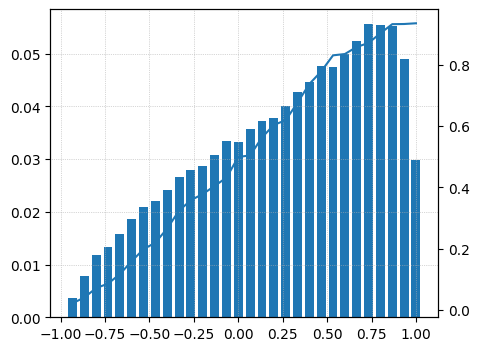

In [66]:
fig, ax = plt.subplots(1,1,figsize=(5,4))

data_list = []
for year in np.arange(2001,2021):
    stats_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/tracks_stats_phase/')
    ds = xr.open_dataset(stats_dir / 'featstats_tracks_non2mcs_{}.tropics30NS.full.nc'.format(year))
    data_list.extend(ds.corr_coeff_temp.values)
data = np.asarray(data_list)
data = data[~np.isnan(data)]
(samples, bins) = np.histogram(data, bins=30)
mu, std = norm.fit(samples)
# Calculate the CDF using the normal distribution with fitted parameters
cdf_values = norm.cdf(np.sort(samples), loc=mu, scale=std)
ax.bar(bins[1:], samples/np.sum(samples), width=0.05)
ax2 = ax.twinx()
ax2.plot(bins[1:], cdf_values)
ax.grid(ls=':',lw=0.5)

In [62]:
samples

array([ 22,  45,  39,  49,  81,  86, 116, 103, 105, 123, 131, 124, 115,
       157, 147, 152, 184, 149, 173, 193, 203, 213, 208, 230, 245, 261,
       244, 226, 212, 137])